In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scIB

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.3 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.20.4 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # Ignore R warning messages
import rpy2.robjects as ro
import anndata2ri

In [3]:
plt.rcParams['figure.figsize'] = 8,8

In [4]:
adata = sc.read("../data/tm/facs/norm/Limb_Muscle_raw.h5ad", cache=True)

In [5]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 5033 genes that are detected in less than 1 cells


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

Number of highly variable genes: 4000
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02.06)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/icb/

    finished (0:00:04.63) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:08.88) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.16) --> found 7 clusters and added
    'louvain_post', the cluster labels (adata.obs, categorical)


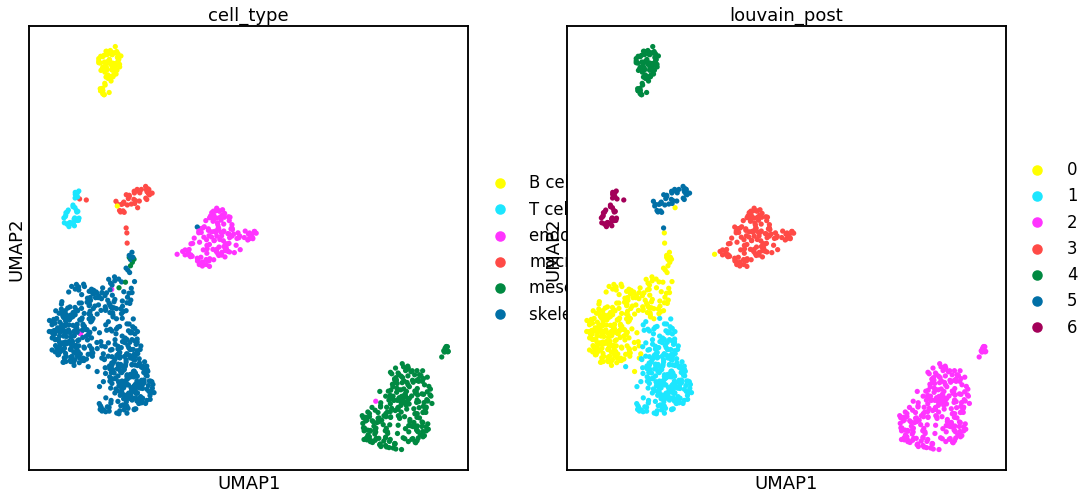

In [6]:
scIB.preprocessing.reduce_data(adata, hvg=True, pca=True, umap=True)
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_post')

sc.pl.umap(adata, color=['cell_type', 'louvain_post'], palette=sc.pl.palettes.godsnot_64)

In [8]:
anndata2ri.activate()

In [9]:
ro.r("library(kBET)")
ro.globalenv['data_mtrx'] = adata.X
ro.globalenv['batch'] = adata.obs['cell_type']

## kBET

In [7]:
adata

AnnData object with n_obs × n_vars = 1090 × 23433 
    obs: 'tissue', 'sample', 'sex', 'cell_type', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'louvain_post'
    uns: 'neighbors', 'louvain', 'cell_type_colors', 'louvain_post_colors'
    obsm: 'X_pca', 'X_umap'

In [8]:
batch_estimate = ro.r("batch.estimate <- kBET(data_mtrx, batch)")
batch_estimate

summary,[RTYPES.VECSXP]
results,[RTYPES.VECSXP]
average.pval,[RTYPES.REALSXP]
stats,[RTYPES.VECSXP]
params,[RTYPES.VECSXP]
outsider,[RTYPES.VECSXP]


In [9]:
ro.r("names(batch.estimate)")

[1] "summary"      "results"      "average.pval" "stats"        "params"      
[6] "outsider"    


array(['summary', 'results', 'average.pval', 'stats', 'params',
       'outsider'], dtype='<U12')

In [12]:
ro.r("batch.estimate$average.pval")[0]

5.825127962211241e-07

In [10]:
anndata2ri.deactivate()

## PC Regression

In [10]:
n_comps = min(sum(adata.var["highly_variable"] == True), adata.n_obs)
n_comps

1090

In [11]:
hvg = (adata.var["highly_variable"] == True)
np.where(hvg)[0]

array([    2,    12,    24, ..., 18380, 18390, 18391])

In [12]:
mtx = adata.X[:, np.where(hvg)[0]]
mtx.shape

(1090, 4000)

In [13]:
adata_pca = sc.tl.pca(mtx, n_comps=n_comps, use_highly_variable=False, return_info=True, svd_solver='full', copy=True)

computing PCA with n_comps = 1090
    finished (0:00:02.11)


In [20]:
[a.shape for a in adata_pca]

[(1090, 1090), (1090, 4000), (1090,), (1090,)]

In [55]:
adata_pca.uns["pca"]

{'variance': array([5.89201293e+02, 4.04977216e+02, 2.82605030e+02, ...,
        3.44458961e-01, 3.35927732e-01, 2.95869152e-27]),
 'variance_ratio': array([9.56515219e-02, 6.57444026e-02, 4.58783806e-02, ...,
        5.59198090e-05, 5.45348409e-05, 4.80316913e-31])}

In [17]:
anndata2ri.activate()

In [46]:
ro.globalenv["X_pca"] = adata_pca.obsm["X_pca"]
ro.globalenv["pca_var"] = adata_pca.uns["pca"]["variance"]
ro.r("pca.data <- list(x=X_pca, sdev=pca_var)")

x,[RTYPES.REALSXP]
sdev,[RTYPES.REALSXP]


In [49]:
# ro.r("batch.silhouette <- batch_sil(pca.data, batch)")
pcr = ro.r("batch.pca <- pcRegression(pca.data, batch, n_top=100)")

In [50]:
pca_regression = dict(zip(pcr.names, list(pcr)))
pca_regression

{'maxVar': array([12.2,  0.4,  0.3,  0.3]),
 'PmaxVar': array([1.e-16, 1.e-16, 1.e-16, 1.e-16]),
 'pcNfrac': array([0.08]),
 'pcRegscale': array([0.42215256]),
 'maxCorr': array([0.97469739]),
 'maxR2': array([0.950035]),
 'msigPC': array([0.99]),
 'maxsigPC': array([0.98]),
 'R2Var': array([0.85679433]),
 'ExplainedVar': array([52.8, 25. , 12.2, ...,  0. ,  0. ,  0. ]),
 'r2': array([[9.50035000e-01, 6.46398043e-03, 1.00000000e-16],
        [9.02345507e-01, 3.62229185e-04, 1.00000000e-16],
        [9.42015453e-01, 1.00000000e-16, 1.00000000e-16],
        ...,
        [2.37033593e-04, 9.39176400e-01, 9.98369477e-01],
        [1.03881384e-04, 8.85181416e-01, 9.99781796e-01],
        [4.98968749e-01, 9.98400059e-01, 6.65684392e-01]])}

In [12]:
pca_regression['pcRegscale'][0]

0.6601307189542484

In [7]:
anndata2ri.deactivate()